# Roandom Forest

## 0. Setup

### 0.1. Install packages

In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install panelsplit
#!pip install openpyxl

### 0.2. Load packages

In [1]:
# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

from panelsplit.cross_validation import PanelSplit

import shap
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import zipfile
import openpyxl

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit  # Alternative to PanelSplit

c:\Users\mmier\anaconda3\envs\MDS_thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.3. Activate GPU

In [13]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### 0.4. Load Data

In [2]:
### Check working directory
#print(os.getcwd()) 

### Define file and path
#file_path = r"c:\Users\mmier\OneDrive - Hertie School\3. Estudio\2025 MDS\2025-1 MDS Thesis\MDS_thesis\Data" #Use a raw string (r"") when defining paths
#print(os.listdir(file_path)) # List files in directory
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"
#full_path = os.path.join(file_path, csv_filename)

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

## 1. Preprocessing

### 1.1. Define train, test and evaluation set

Evaluation set: 2019 to 2022

In [ ]:
### Separate evaluation set 
#final_df = df[df["AÑO"] < 2019]

### 1.2. Define y and X1

y: deforestation

X1: general variables

In [4]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])
#y = y.to_numpy()

# Normalize output
#scaler = StandardScaler()

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 


# Keep feature names
original_feature_names = list(X1.columns) 

# Normalize features
#X1 = scaler.fit_transform(X1)

## 1. Random Forest with Scikitlearn

### 6.1. Define panel splits 

In [5]:
from panelsplit.cross_validation import PanelSplit

### Initialize PanelSplit
panel_split = PanelSplit(periods=final_df.year, n_splits=5)
splits = panel_split.split()

### Check splits, for n_splits=3
splits_1_train = final_df.loc[splits[0][0]]
splits_1_test = final_df.loc[splits[0][1]]
splits_2_train = final_df.loc[splits[1][0]]
splits_2_test = final_df.loc[splits[1][1]]
splits_3_train = final_df.loc[splits[2][0]]
splits_3_test = final_df.loc[splits[2][1]]



### 6.2. Train a Quick Random Forest to Identify Important Features

Before running the full model, we train a baseline Random Forest to rank feature importance.

In [5]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define a baseline Random Forest model
rf_baseline = RandomForestRegressor(
    n_estimators=50,  # Small number of trees for quick evaluation
    max_depth=10,     # Limit tree depth to avoid overfitting
    random_state=17,
    n_jobs=-1         # Use all CPU cores
)

# Fit the model on the full dataset (ignoring "AÑO" and "Municipio" for now)
rf_baseline.fit(X1, y)

# Extract feature importance
feature_importance_df = pd.DataFrame({
    "Feature": X1.columns,
    "Importance": rf_baseline.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display the top 30 features
print(feature_importance_df.head(30))
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Top Feature Importance", dataframe=feature_importance_df.head(3))



# Keep only the top 30 most important features
#top_features = feature_importance_df["Feature"].head(30).tolist()


# Update X1 to only include the top features
#X1 = X1[top_features]

#print(f"✅ Selected top {len(top_features)} features for the final model.")

          Feature  Importance
13         H_coca    0.218206
5       disbogota    0.069497
14   errad_manual    0.041283
67        C-03-14    0.031512
23      e_tortura    0.030593
60      INS-01-8c    0.026947
3      discapital    0.025323
25  eventos_minas    0.025114
55       GPI-03-0    0.023562
36       SOS-03-6    0.021766
63       PCC-01-0    0.021737
65       PCC-01-2    0.019785
21     e_desplaza    0.019697
7        pobl_urb    0.019636
4          dismdo    0.019216
69       PCC-02-4    0.017593
47      CV-03-31e    0.016529
33        M-03-15    0.016204
37       CV-03-16    0.015866
27       CTI-02-0    0.014098
10        total_r    0.013541
44       EIS-01-0    0.012518
53       GPI-01-0    0.011789
0          gdp_pc    0.011556
11      total_nuf    0.011178
8        total_as    0.010622
50       CV-03-26    0.010504
52       EIS-03-3    0.010422
12      total_vrf    0.010028
1            iica    0.010016


### 6.3.  Train the Final Random Forest Model

"Manual tunning"

In [6]:
import pandas as pd

### Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

### Define hyperparameters for tuning
n_estimators_values = [50, 100, 200, 300]  # Number of decision trees in the Random Forest model
max_depth_values = [5, 10, 20, None]       # Maximum depth of each tree (controls complexity)

### Initialize Storage for Results
results = {}

### Setup panle data cross validation with  PanelSplit
panel_split = PanelSplit(periods=final_df.year, n_splits=5, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped

### Loop through Cross-Validation Splits
for train_idx, test_idx in panel_split.split(X1, y):
#panel_split.split(X, y) iterates through each fold, providing indices for training and testing
    
    ## Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ## Loop over hyperparameters combination
    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:
            
            # Define the Random Forest model
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=17,
                n_jobs=-1  # Use all available processors
            )
            
            # Train the model
            model.fit(X1_train, y_train)

            # Predictions
            y_train_pred = model.predict(X1_train)
            y_test_pred = model.predict(X1_test)

            # Compute performance metrics
            from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
            mse = mean_squared_error(y_test, y_test_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_test_pred)
            r2_test = r2_score(y_test, y_test_pred)
            r2_train = r2_score(y_train, y_train_pred)
            # Compute Adjusted R²
            n_train, k = X1_train.shape
            n_test = X1_test.shape[0]
            adj_r2_train = adjusted_r2(r2_train, n_train, k)
            adj_r2_test = adjusted_r2(r2_test, n_test, k)

            # Store results
            if (n_estimators, max_depth) not in results:
                results[(n_estimators, max_depth)] = []

            results[(n_estimators, max_depth)].append({
                "MSE": mse, "RMSE": rmse, "MAE": mae, "R2_test": r2_test, "R2_train": r2_train, "Adj_R2_test": adj_r2_test, "Adj_R2_train": adj_r2_train
            })

### Compute Average Performance Across Folds
averaged_results = {
    params: {metric: np.mean([fold[metric] for fold in folds])
             for metric in folds[0].keys()}
    for params, folds in results.items()
}

### Find the best hyperparameter combination
best_params = min(averaged_results, key=lambda x: (averaged_results[x]["MSE"], -averaged_results[x]["R2_test"]))
best_metrics = averaged_results[best_params]

### Print optimal hyperparameters and performance
print(f"🌲 Best Random Forest Parameters: n_estimators={best_params[0]}, max_depth={best_params[1]}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")

🌲 Best Random Forest Parameters: n_estimators=300, max_depth=20
📊 Best MSE: 0.0047
📊 Best RMSE: 0.0678
📊 Best MAE: 0.0378
📊 R² (Train): 0.9306
📊 R² (Test): 0.6179
📊 Adj. R² (Train): 0.9301
📊 Adj. R² (Test): 0.5923


🌲 Best Random Forest Parameters: n_estimators=300, max_depth=20
📊 Best MSE: 0.0047
📊 Best RMSE: 0.0678
📊 Best MAE: 0.0378
📊 R² (Train): 0.9306
📊 R² (Test): 0.6179
📊 Adj. R² (Train): 0.9301
📊 Adj. R² (Test): 0.5923

In [7]:
import joblib

# Save the model to a file
joblib.dump(model, "rf_model.pkl")

# Load the model from the file
#loaded_model = joblib.load("random_forest_model.pkl")

# Use it for prediction
#y_pred = loaded_model.predict(X1)

['rf_model.pkl']

NameError: name 'y_true' is not defined

<Figure size 800x600 with 0 Axes>

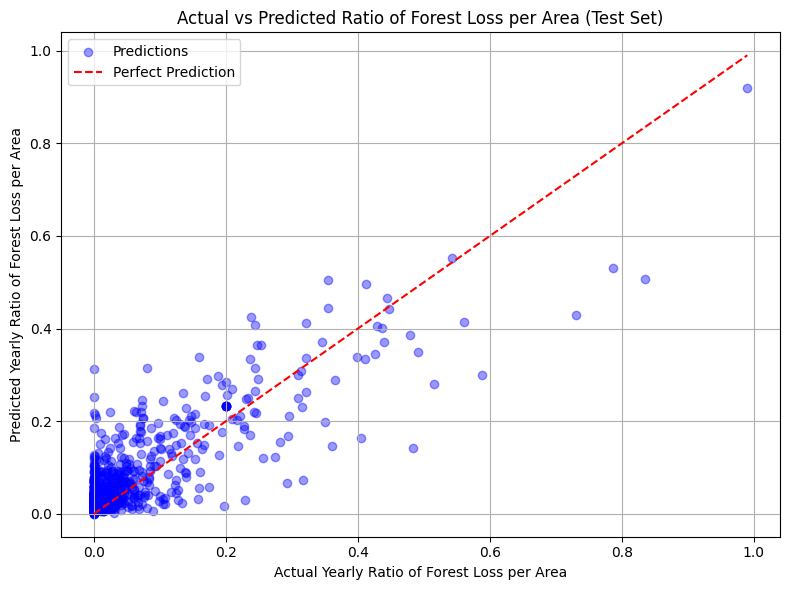

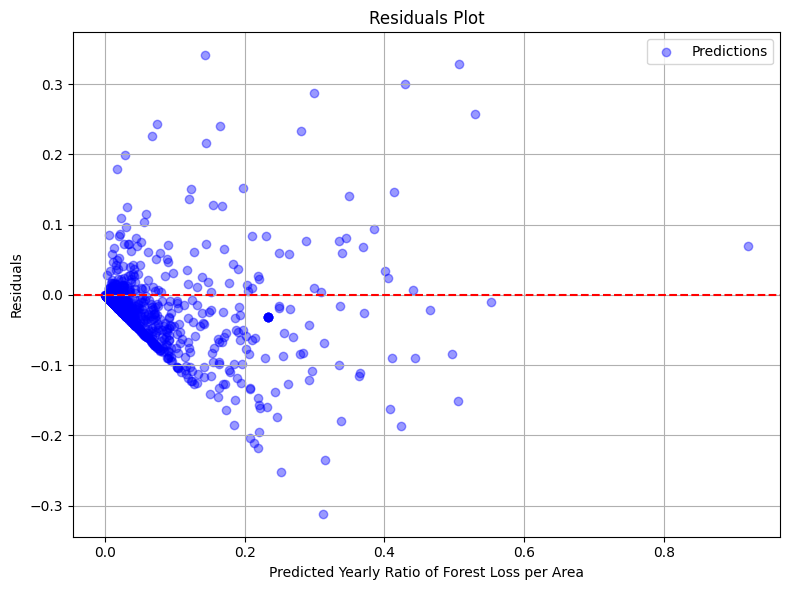

In [20]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'XGBoost - mena absolut SHAP values (Top 10 Features)')

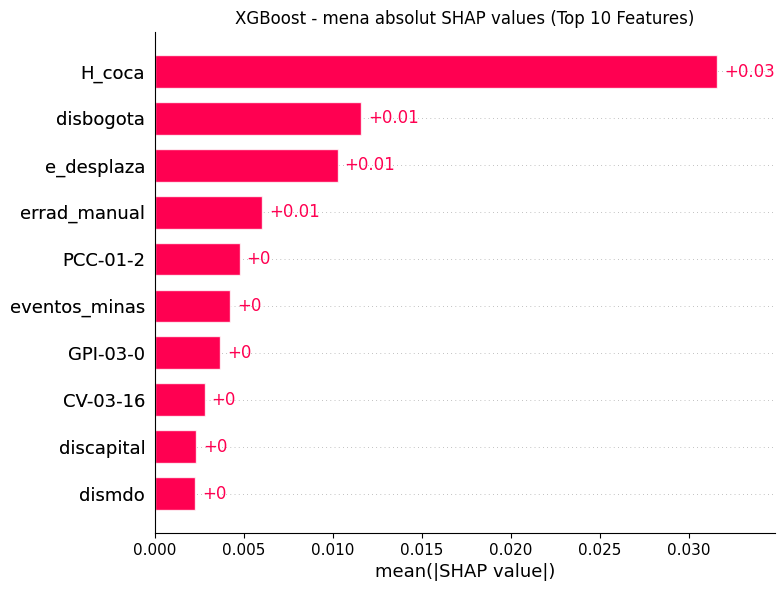

In [ ]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.Explainer(model)
shap_values = explainer(X1_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Random Forest - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


### 6.4. Search grid

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

### Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500, 700],  
    "max_depth": [5, 10, 20],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4]
}

### Setup panel data cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped

# Define the RandomForestRegressor model
model = RandomForestRegressor(random_state=17, n_jobs=-1)

# Setup GridSearchCV with PanelSplit cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=panel_split.split(X1, y),  # Custom panel CV
    n_jobs=-1,  # Parallel computation
    verbose=2
)

# Run grid search
grid_search.fit(X1, y)

# Extract best model and hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Store results for best hyperparameters
results = []

# Iterate through each fold for evaluation
for train_idx, test_idx in panel_split.split(X, y):
    # Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the best model on the current fold
    best_model.fit(X1_train, y_train)

    # Make predictions
    y_train_pred = best_model.predict(X1_train)
    y_test_pred = best_model.predict(X1_test)

    # Compute performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Compute Adjusted R²
    n_train, k = X1_train.shape
    n_test = X1_test.shape[0]
    adj_r2_train = adjusted_r2(r2_train, n_train, k)
    adj_r2_test = adjusted_r2(r2_test, n_test, k)

    # Store results
    results.append({
        "MSE": mse_test,
        "RMSE": rmse_test,
        "MAE": mae_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Adj_R2_train": adj_r2_train,
        "Adj_R2_test": adj_r2_test
    })

# Compute average performance across folds
best_metrics = {metric: np.mean([fold[metric] for fold in results]) for metric in results[0].keys()}

### Print optimal hyperparameters and performance
print(f"🌲 Best Random Forest Parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


NameError: name 'X' is not defined

Fitting 3 folds for each of 180 candidates, totalling 540 fits
🌲 Best Random Forest Parameters: n_estimators=700, max_depth=None
📊 Best MSE: 709110.1742
📊 Best RMSE: 821.6917
📊 Best MAE: 170.5814
📊 R² (Train): 0.4968
📊 R² (Test): 0.0701
📊 Adj. R² (Train): 0.4965
📊 Adj. R² (Test): 0.0642 

### 6.5. Search random

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set seed for reproducibility
seed_value = 17
np.random.seed(seed_value)

### Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

### Define hyperparameter space
param_distributions = {
    "n_estimators": np.random.randint(100, 1000, 10).tolist(),  # Random values from 100 to 1000
    "max_depth": [3, 5, 10, 20, None],  
    "min_samples_split": np.random.randint(2, 15, 5).tolist(),  
    "min_samples_leaf": np.random.randint(1, 10, 5).tolist()
}

### Setup panel data cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=5, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped

# Define the RandomForestRegressor model
model = RandomForestRegressor(random_state=17, n_jobs=-1)

# Setup RandomizedSearchCV with PanelSplit cross-validation
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,  # Number of random samples to try
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=panel_split.split(X1, y),  # Custom panel CV
    n_jobs=-1,  # Parallel computation
    verbose=2,
    random_state=42
)

# Run random search
random_search.fit(X1, y)

# Extract best model and hyperparameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Store results for best hyperparameters
results = []

# Iterate through each fold for evaluation
for train_idx, test_idx in panel_split.split(X1, y):
    # Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the best model on the current fold
    best_model.fit(X1_train, y_train)

    # Make predictions
    y_train_pred = best_model.predict(X1_train)
    y_test_pred = best_model.predict(X1_test)

    # Compute performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Compute Adjusted R²
    n_train, k = X1_train.shape
    n_test = X1_test.shape[0]
    adj_r2_train = adjusted_r2(r2_train, n_train, k)
    adj_r2_test = adjusted_r2(r2_test, n_test, k)

    # Store results
    results.append({
        "MSE": mse_test,
        "RMSE": rmse_test,
        "MAE": mae_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Adj_R2_train": adj_r2_train,
        "Adj_R2_test": adj_r2_test
    })

# Compute average performance across folds
best_metrics = {metric: np.mean([fold[metric] for fold in results]) for metric in results[0].keys()}

### Print optimal hyperparameters and performance
print(f"🌲 Best Random Forest Parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"📊 Adj. R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 Adj. R² (Test): {best_metrics['Adj_R2_test']:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
🌲 Best Random Forest Parameters: n_estimators=490, max_depth=None
📊 Best MSE: 0.0045
📊 Best RMSE: 0.0668
📊 Best MAE: 0.0370
📊 R² (Train): 0.8838
📊 R² (Test): 0.6297
📊 Adj. R² (Train): 0.8829
📊 Adj. R² (Test): 0.6049


Fitting 3 folds for each of 30 candidates, totalling 90 fits
🌲 Best Random Forest Parameters: n_estimators=853, max_depth=20
📊 Best MSE: 706687.1554
📊 Best RMSE: 819.8642
📊 Best MAE: 168.8173
📊 R² (Train): 0.3132
📊 R² (Test): 0.0754
📊 Adj. R² (Train): 0.3128
📊 Adj. R² (Test): 0.0696

In [7]:
import joblib

# Save the model to a file
joblib.dump(model, "random_forest_model.pkl")

# Load the model from the file
#loaded_model = joblib.load("random_forest_model.pkl")

# Use it for prediction
#y_pred = loaded_model.predict(X1)

['random_forest_model.pkl']

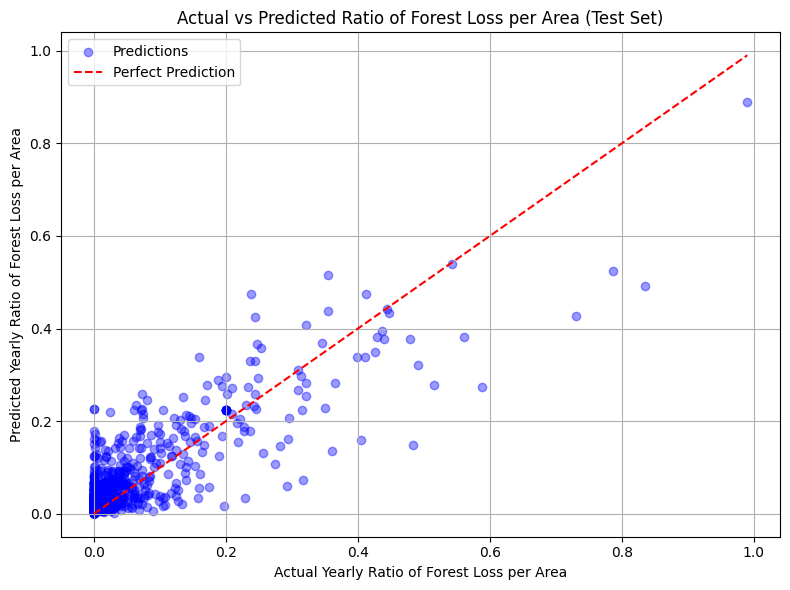

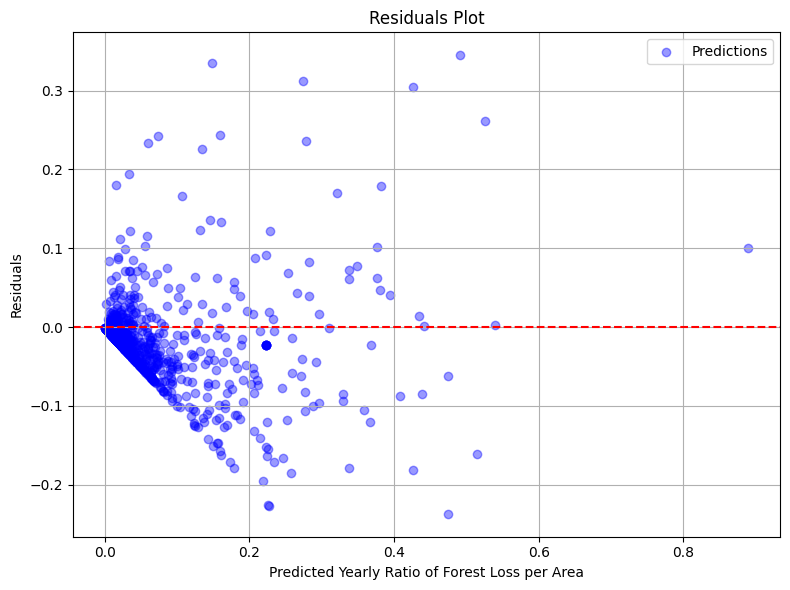

In [8]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SHAP

Text(0.5, 1.0, 'XGBoost - mena absolut SHAP values (Top 10 Features)')

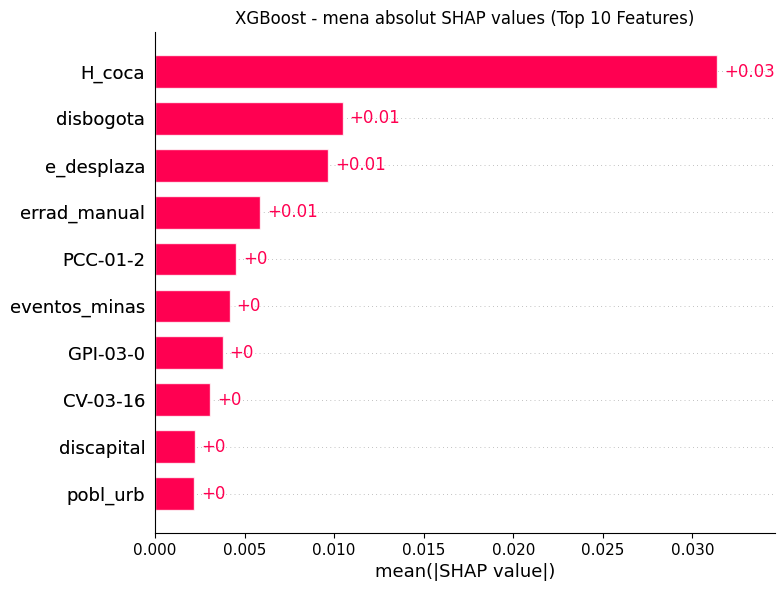

In [14]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X1_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Random Forest - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


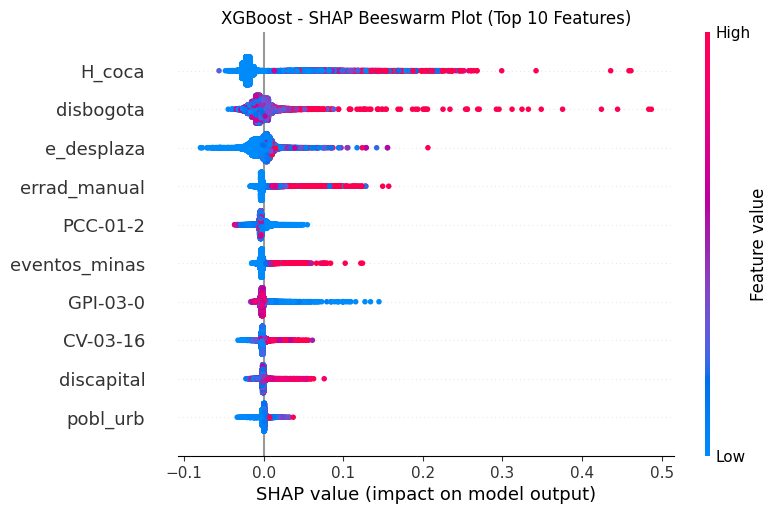

In [15]:
plt.figure(figsize=(16, 10))  
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("XGBoost - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”